# Calculate advection in ANHA4

In [3]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts

In [4]:
import glob
import datetime
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [5]:
def central_diff(T):
    '''
    % =========================================================================== %
    % Central diffference for inner domain; forward/backward difference for edges 
    %   build-in function
    % =========================================================================== %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/25
    % =========================================================================== %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    # Get the length of x, y dimension
    M = np.size(T, axis=0)
    N = np.size(T, axis=1)
    # Allocation
    dx = np.zeros(T.shape)
    dy = np.zeros(T.shape)
    # dx
    dx[:, 0] = T[:, 1]-T[:, 0]
    dx[:,-1] = T[:,-1]-T[:,-2]
    for i in range(1, N-1):
        dx[:, i] = 0.5*(T[:, i+1]-T[:, i-1])
    # dy
    dy[0, :] = T[1, :]-T[0, :]
    dy[-1,:] = T[-1,:]-T[-2,:]
    for i in range(1, M-1):
        dy[i, :] = 0.5*(T[i+1, :]-T[i-1, :])
    return dx, dy

In [6]:
def dx_atmos(lon, lat):
    '''
    % ======================================================================= %
    % Calculate the grid distance on the earth,
    %   dy=dx*h1, h1=R*sin(phi)=R*cos(lat)
    %       (h1 is the scale factor in spherical coordinate)
    %   build-in function
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/25
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    R = 6.3781e6 # earth radius (m)
    dx, _ = central_diff(lon)
    dx = dx * (np.pi/180.0)*R*np.cos(lat*np.pi/180.0)
    return dx

In [7]:
def dy_atmos(lat):
    '''
    % ======================================================================= %
    % Calculate grid distance on Earth, 
    %   dy=dy*h2, h2=R
    %       (h2 is scale factor in spherical coordinate)
    %   build-in function
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/25
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    R = 6.3781e6 # earth radius (m)
    _, dy = central_diff(lat)
    dy = dy*(np.pi/180.0)*R
    return dy
    

In [75]:
def advh_atmos(lon, lat, u, v, T):
    '''
    % ======================================================================= %
    % Calculate horizontal advection
    % Input
    %   longitude: Longitude, deg
    %   latitude: Latitude, deg
    %   u: Zonal Wind, m/s
    %   v: Meditorial Wind, m/s
    %   T: Scalar field
    % Output
    %   advh: Horizontal Advection of T, unit(T)*s^-1
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/27
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    R=6.3781e6 # earth radius (m)
    dx = dx_atmos(lon, lat)
    dy = dy_atmos(lat)
    dTx, dTy = central_diff(T)
    advh=-(v*dTy/dy+u*dTx/dx)
    advh[np.abs(lat)>88]=np.nan;
    return advh

In [85]:
def curlz_atmos(lon, lat, u, v):
    '''
    % curlz=curlz_atmos(longitude, latitude, u, v)
    %   Calculate vorticity in vertical direction
    % ======================================================================= %
    % Input
    %   longitude: Longitude, deg
    %   latitude: Latitude, deg
    %   u: Zonal Wind, m/s
    %   v: Meditorial Wind, m/s
    % Output
    %   curlz: Vorticity in vertical direction, s^-1
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/2/27
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/25
        yingkai@eos.ubc.ca
    '''
    R = 6.3781e6; # earth's radius (m)
    dx = dx_atmos(lon, lat);
    dy = dy_atmos(lat);
    _, du = central_diff(u);
    dv, _ = central_diff(v);
    curlz = dv/dx-du/dy+u*np.tan(lat*np.pi/180.0)/R;
    curlz[np.abs(lat)>88]=np.nan;
    return curlz

# A test of dx, dy

In [10]:
x = np.linspace(-180, 180, 180)
y = np.linspace(0, 90, 45)
lon, lat = np.meshgrid(x, y)

In [11]:
dx = dx_atmos(lon, lat)
dy = dy_atmos(lat)

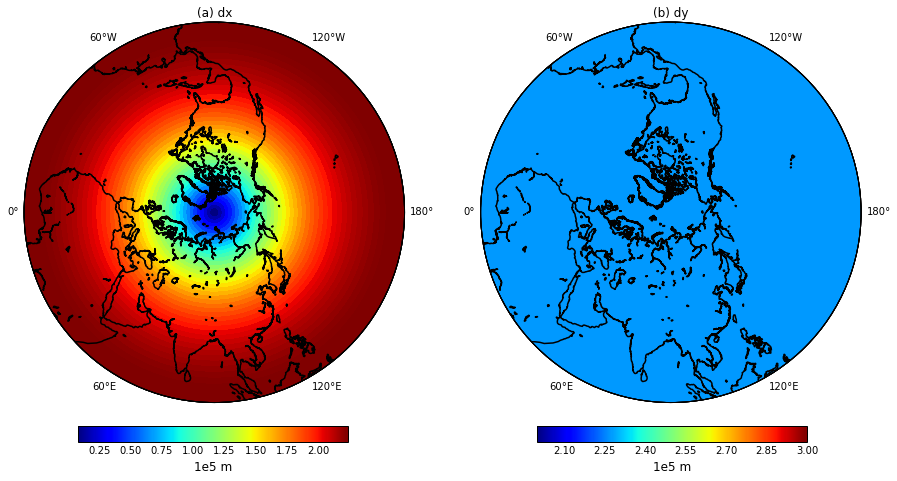

In [13]:
fig=plt.figure(figsize=(15, 15))

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

proj=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.drawcoastlines(linewidth=1.5, color='k', zorder=4)
x, y = proj(lon, lat)
CS = proj.pcolor(x, y, dx*1e-5, cmap=plt.cm.jet)
#proj.plot(x, y, 'k-', lw=0.25); proj.plot(x.T, y.T, 'k-', lw=0.25);
ax1.set_title('(a) dx')

cax = fig.add_axes([0.175, 0.3, 0.25, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('1e5 m', fontsize=12)
CBar.ax.tick_params(axis='x', length=0)

proj=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.drawcoastlines(linestyle='-', color='k', linewidth=1.5, zorder=3)
x, y = proj(lon, lat)
CS = proj.pcolor(x, y, dy*1e-5, vmin=2, vmax=3, cmap=plt.cm.jet)
#proj.plot(x, y, 'k-', lw=0.25); proj.plot(x.T, y.T, 'k-', lw=0.25);
ax2.set_title('(b) dy')

cax = fig.add_axes([0.6, 0.3, 0.25, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('1e5 m', fontsize=12)
CBar.ax.tick_params(axis='x', length=0)

In [89]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [90]:
coordinate_name=glob.glob('../../_data/Exchange/coordinates_ANHA4.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]

In [91]:
names = sorted(glob.glob('../../_data/MAT files/REMAP_Ba_UV/*'))

In [92]:
x = np.linspace(-180, 180, 180)
y = np.linspace(60, 90, 60)
lon, lat = np.meshgrid(x, y)

In [93]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BARIUM01_1m_20020101_20140103_ptrc_T.nc'

In [94]:
ptrc_obj = nc.Dataset(FName)
#Ba = np.squeeze(ptrc_obj.variables['Ba'][0, 0, :, :])
#d18O = np.squeeze(ptrc_obj.variables['d18O'][:, 0, :, :])
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

# Dissolved Barium advection

local time derivative = adv + conv + diffu + sms + decay:

$$
\frac{\partial T}{\partial t} = \vec{v}\cdot\nabla T + w\frac{\partial T}{\partial z} + \nu\Delta T + SMS(x, y, t) + \lambda T
$$

Advection term in finite difference:

$$
\vec{v}\cdot\nabla T = u\frac{\delta T}{\delta x} + v\frac{\delta T}{\delta y}
$$

In [72]:
def plot_advh(lon, lat, U, V, T, lev, mag, time, ax):

    advh = advh_atmos(lon, lat, U, V, T)
    #
    proj=Basemap(projection='npstere', resolution='l', boundinglat=62, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(lon, lat)

    CS = proj.contourf(x, y, advh*mag, lev, cmap=plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, advh*mag, lev, colors=('gray',), linewidths=(1.0,))
    return CS, proj

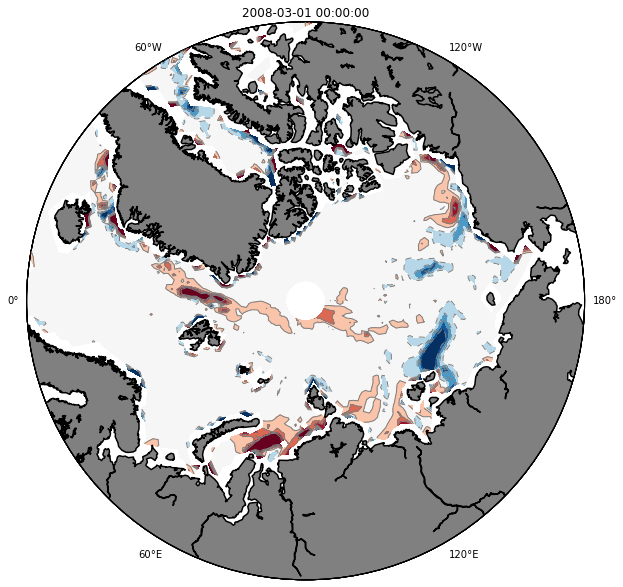

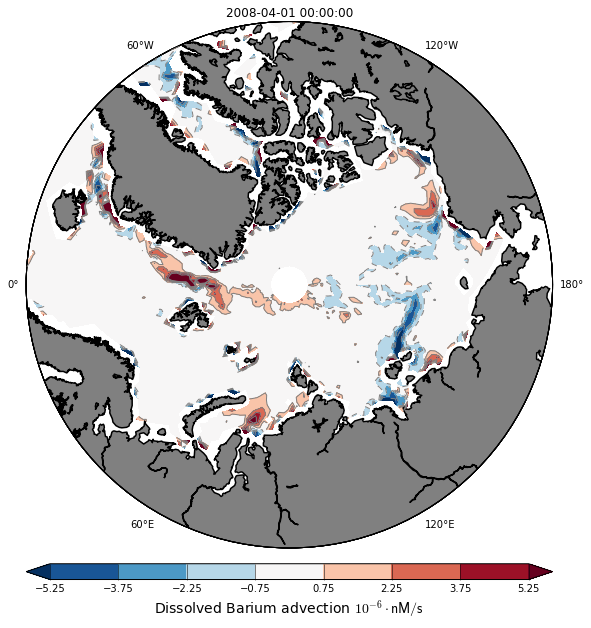

In [83]:
lev = np.array([-1.05, -0.75, -0.45, -0.15, 0.15, 0.45, 0.75, 1.05])*5

for i in range(74, 76):
    #print(names[i])
    MAT = scipy.io.loadmat(names[i])
    U = MAT['u']
    V = MAT['v']
    T = MAT['Ba'][0, :, :]
    U[U>1e7]=np.nan
    V[V>1e7]=np.nan
    T[T==0]=np.nan
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    CS, proj = plot_advh(lon, lat, U, V, T, lev, 1e6, i, ax)
    ax.set_title(date_list[i])
    
CBar=proj.colorbar(CS, location='bottom', size='3%', pad='3%', ticks=lev)
CBar.set_label('Dissolved Barium advection $\mathsf{10^{-6}\cdot nM/s}$', fontsize=14)
CBar.ax.tick_params(axis='x', length=16)

In [100]:
# Check if per month
print(' If 2.25e-6 nM/s then {} nM/month'.format(60*60*24*30*2.25e-6))

 If 2.25e-6 nM/s then 5.832 nM/month


I think Ba anomaly @ BG in Mar 2008 is due to the advection. 

# Relative vorticity of the ocean currents

Apply:

$$
\zeta_z = \frac{dv}{dx}-\frac{du}{dy}
$$

Then relate it with lon/lat (see *Wikipedia - Del in cylindrical and spherical coordinates*)

In [88]:
def plot_curlz(lon, lat, U, V, lev, time, ax):

    curlz = curlz_atmos(lon, lat, U, V)
    #
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(lon, lat)

    CS = proj.contourf(x, y, curlz*1e6, lev, cmap=plt.cm.RdBu_r, extend='both')
    return CS, proj

../../_data/MAT files/REMAP_Ba_UV/REMAP_Ba_UV_074.mat
../../_data/MAT files/REMAP_Ba_UV/REMAP_Ba_UV_075.mat


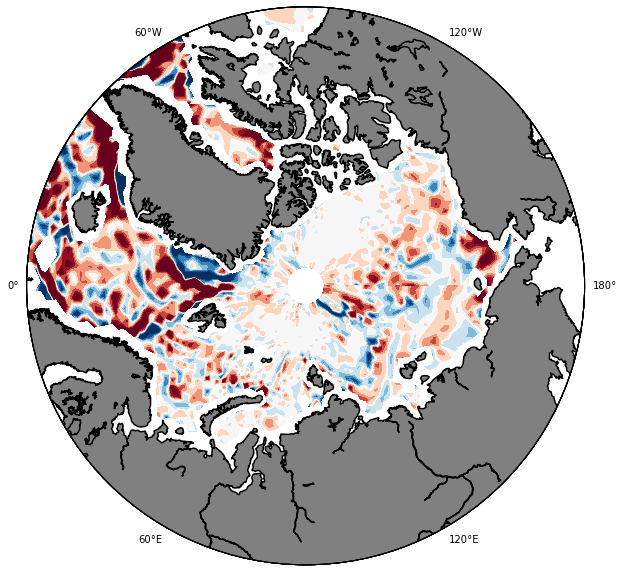

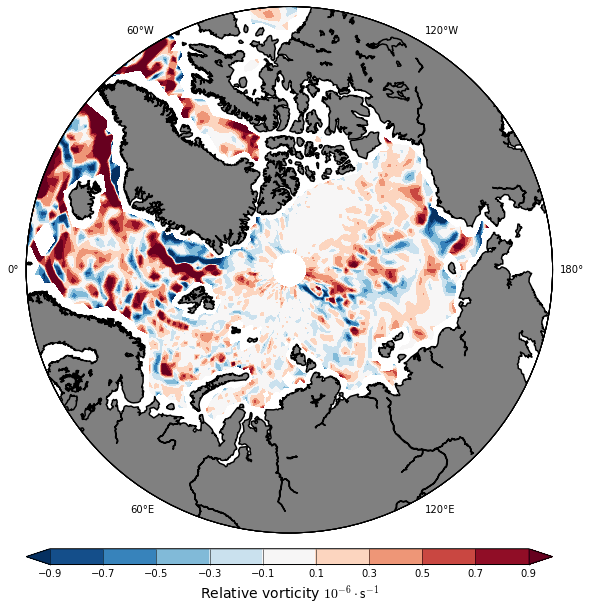

In [87]:
lev = np.array([-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9])

for i in range(74, 76):
    print(names[i])
    MAT = scipy.io.loadmat(names[i])
    U = MAT['u']
    V = MAT['v']
    U[U>1e7]=np.nan
    V[V>1e7]=np.nan
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    CS, proj = plot_curlz(lon, lat, U, V, lev, i, ax)
    
CBar=proj.colorbar(CS, location='bottom', size='3%', pad='3%', ticks=lev)
CBar.set_label('Relative vorticity $\mathsf{10^{-6}\cdot s^{-1}}$', fontsize=14)
CBar.ax.tick_params(axis='x', length=16)